In [1]:
# Shaimae Elhajjajy
# February 26, 2024
# Run ArchR scRNA-seq integration on the 10X Multiome PBMC scATAC 10K data, but using results from anchoring analyses on cCREs
# Note! Run with singularity image archr_seuratv4.sif

In [2]:
# Load libraries
library(ArchR)
library(Seurat)
library(SeuratObject)
library(SummarizedExperiment)
library(tidyverse)
library(patchwork)
packageVersion("Seurat")
packageVersion("Matrix")
packageVersion("ggplot2")


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

[1] ‘4.3.0’

[1] ‘1.6.5’

[1] ‘3.4.4’

In [3]:
# Parameters
set.seed(99)
addArchRThreads(threads = 16)

Setting default number of Parallel threads to 16.



In [4]:
# Load in custom genome
library(BSgenome.GRCh38.ENCODE, lib.loc = "/data/zusers/elhajjajys/genomes/BSgenome/GRCh38")

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:purrr’:

    compact


The following object is masked from ‘package:plyr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:grid’:

    pattern


The following object is masked from ‘package:base’:

    strsplit


Loading required package: BiocIO

Loading required package: rtracklayer


Attaching package: ‘rtracklayer’


The following object is masked from ‘package:BiocIO’:

    FileForFormat




In [5]:
# Set location of GENCODE annotation
GENOMES_DIR = "/data/zusers/elhajjajys/genomes"
GTF_BASE = "gencode.v40.basic.annotation"

In [6]:
# Read in blacklisted regions (i.e., exclusion set)
# Note: this is the official ENCODE blacklist for hg38, and is also built-in to Signac.
blacklist_df = fread(paste0(GENOMES_DIR, "/GRCh38.ENCODE.blacklist.ENCFF356LFX.bed"), sep = "\t")
colnames(blacklist_df) = c("chr", "start", "end")
blacklist_gr = makeGRangesFromDataFrame(blacklist_df, keep.extra.columns = TRUE)

In [7]:
# Create genome annotation (to infer chromosome sizes)
genomeAnnotation <- createGenomeAnnotation(genome = BSgenome.GRCh38.ENCODE, blacklist = blacklist_gr)

Getting genome..

Attempting to infer chromSizes..

Using provided blacklist...



In [8]:
# Create general gene reference (all genes)
genes_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".gene.bed"), sep = "\t")
colnames(genes_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
genes_gr = makeGRangesFromDataFrame(genes_df, keep.extra.columns = TRUE)

exons_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".exon.bed"), sep = "\t")
colnames(exons_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
exons_gr = makeGRangesFromDataFrame(exons_df, keep.extra.columns = TRUE)

tss_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".TSS.bed"), sep = "\t")
colnames(tss_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
tss_gr = makeGRangesFromDataFrame(tss_df, keep.extra.columns = TRUE)

geneAnnotation <- createGeneAnnotation(
  TSS = tss_gr,
  exons = exons_gr,
  genes = genes_gr
)

In [9]:
# Set directory where data is located
WORKING_DIR = "/zata/zippy/phanh/encode/snMultiome/adult_heart"
DATA_DIR = paste0(WORKING_DIR, "/snATAC/bams")
# Set output directory
OUT_DIR = paste0(WORKING_DIR, "/anchored_on_cCREs_w_integration") 

In [10]:
# Read in ArchR object (from PBMC scMultiome 10K data, anchored on cCREs)
proj = loadArchRProject(path = paste0(WORKING_DIR, "/anchored_on_cCREs_w_integration/ArchROut_ENCSR681OLJ"), force = TRUE, showLogo = FALSE)

Successfully loaded ArchRProject!



In [11]:
# View available matrices to see what is available (should only be GeneScoreMatrix and TileMatrix)
getAvailableMatrices(proj)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "PeakMatrix"           
[4] "TileMatrix"

In [12]:
# Load the ENCODE snRNA adult heart dataset
# adult_heart_data <- Read10X(data.dir = "/zata/zippy/phanh/encode/snMultiome/adult_heart/heart.left.ventricle.ENCSR012APQ.ENCFF696DZL/filtered")
adult_heart_data <- Read10X(data.dir = "/zata/zippy/phanh/encode/snMultiome/adult_heart/heart.right.ventricle.ENCSR258SZI.ENCFF289QCB/filtered", gene.column = 1)
# Initialize the Seurat object with the raw (non-normalized data).
adult_heart <- CreateSeuratObject(counts = adult_heart_data, min.cells = 3, min.features = 200)

In [13]:
annotation_all <- read.table("/zata/zippy/phanh/encode/snMultiome/adult_heart/cell.types.snRNA.tsv", sep="\t", header=T)
annotation <- annotation_all %>% filter(rna_dataset == "ENCSR258SZI")

In [14]:
adult_heart@meta.data$rna_barcode <- rownames(FetchData(adult_heart, "ident"))
adult_heart@meta.data <- left_join(adult_heart@meta.data, annotation, by="rna_barcode")
adult_heart@meta.data[["cell_type_name"]] <- factor(adult_heart@meta.data[["cell_type_name"]])
cell_type <- adult_heart@meta.data[["cell_type_name"]]
adult_heart$cluster <- cell_type
adult_heart$cluster

AAACAGCCAAACTCAT   AAACATGCAAGGAATC   AAACATGCAATTTAGC   AAACATGCACCTATAG 
              <NA>         fibroblast         fibroblast               <NA> 
  AAACATGCAGCTTAGC   AAACATGCAGGTTTGC   AAACATGCAGTAGGAT   AAACATGCATGGCCTG 
              <NA>               <NA>   endothelial_cell   endothelial_cell 
  AAACCAACAAACTCAT   AAACCAACAAGGGTTG   AAACCAACAAGGTGGC   AAACCAACACAACAGG 
              <NA>         fibroblast               <NA>               <NA> 
  AAACCAACACAACCTA   AAACCAACAGGAAGCC   AAACCAACAGGTTAAA   AAACCAACAGGTTTGC 
          pericyte               <NA>               <NA>               <NA> 
  AAACCAACATCCATCT   AAACCAACATTAGCCA   AAACCGAAGAATCGCT   AAACCGAAGACAAGTG 
        fibroblast         fibroblast               <NA>               <NA> 
  AAACCGAAGCGATACT   AAACCGAAGGGTCTAT   AAACCGAAGGGTTATC   AAACCGAAGGTGAAAT 
              <NA>         fibroblast               <NA>               <NA> 
  AAACCGAAGTCAGGCC   AAACCGAAGTCCTTCA   AAACCGCGTACCGAAC   AAACCGCGTCATAGAT 
              <NA>               <NA>               <NA>         fibroblast 
  AAACCGCGTCGACTAA   AAACCGCGTCGTAATG   AAACCGCGTTAGGTGC   AAACCGCGTTGTAACG 
     cardiomyocyte               <NA>               <NA>         macrophage 
  AAACCGGCAACCCTAA   AAACCGGCAATGAGGT   AAACCGGCAATGCCTA   AAACCGGCACAGAACG 
              <NA>           pericyte               <NA>               <NA> 
  AAACCGGCACCTACTT   AAACCGGCAGCCTTGG   AAACCGGCAGGCTTGT   AAACGCGCAATACTGT 
        fibroblast               <NA>   endothelial_cell               <NA> 
  AAACGCGCACTAAATC   AAACGCGCACTAAGAA   AAACGCGCAGGCGAGT   AAACGCGCAGTAGGAT 
        fibroblast               <NA>           pericyte         fibroblast 
  AAACGCGCATGCAACC   AAACGCGCATGGTTAT   AAACGGATCAGGAACA   AAACGGATCATGACCG 
              <NA>           pericyte               <NA>           pericyte 
  AAACGGATCATGCCTC   AAACGGATCATTAGGC   AAACGGATCCCGAACA   AAACGGATCCTAAATG 
              <NA>               <NA>               <NA>               <NA> 
  AAACGGATCCTGGCTT   AAACGGATCGAGCTAT   AAACGGATCGATCAGT   AAACGGATCGCTAGTG 
              <NA>               <NA>      cardiomyocyte               <NA> 
  AAACGGATCGTAATCA   AAACGGATCGTTAACA   AAACGGATCTAACCTT   AAACGTACAAACTCAT 
     cardiomyocyte         fibroblast   endothelial_cell      cardiomyocyte 
  AAACGTACAATTGACT   AAACGTACACCTACTT   AAACGTACACGTAATT   AAACGTACACTCAACA 
              <NA>               <NA>      cardiomyocyte               <NA> 
  AAACGTACAGGAACCA   AAACGTACAGGATTAA   AAACGTACAGGCCATT   AAAGCAAGTAACAGGG 
              <NA>               <NA>               <NA>               <NA> 
  AAAGCAAGTAAGGTTT   AAAGCAAGTAGCCTAA   AAAGCAAGTCAAGTAT   AAAGCAAGTGATGATT 
              <NA>               <NA>               <NA>               <NA> 
  AAAGCAAGTGCACGCA   AAAGCAAGTGCGCAAT   AAAGCAAGTTAAGCTG   AAAGCAAGTTAGCCAA 
              <NA>      cardiomyocyte               <NA>   endothelial_cell 
  AAAGCAAGTTATGTGG   AAAGCAAGTTGCGGAT   AAAGCACCACAAAGGT   AAAGCACCAGCAGGTA 
  endothelial_cell               <NA>         fibroblast               <NA> 
  AAAGCACCAGGCAAGC   AAAGCACCAGTCTATG   AAAGCACCATCAATCG   AAAGCCCGTATTTGGG 
              <NA>               <NA>           neuronal               <NA> 
  AAAGCCCGTCATAGAT   AAAGCCCGTCCAAATG   AAAGCCCGTCTTGCAT   AAAGCCCGTGAGGTAG 
          pericyte               <NA>      cardiomyocyte               <NA> 
  AAAGCCCGTTCCGGCT   AAAGCCGCAGATAGAC   AAAGCCGCAGGTTACC   AAAGCCGCATCATGTG 
              <NA>      cardiomyocyte               <NA>               <NA> 
  AAAGCGGGTAGCTGGT   AAAGCGGGTCATTACC   AAAGCGGGTCGTAATG   AAAGCGGGTGATTACG 
              <NA>               <NA>               <NA>               <NA> 
  AAAGCGGGTGGACATC   AAAGCGGGTTAGCAGC   AAAGCGGGTTATCCTA   AAAGCTTGTAAGCACC 
              <NA>      cardiomyocyte               <NA>         fibroblast 
  AAAGCTTGTACGATTG   AAAGCTTGTCAGGAAG   AAAGCTTGTGGGTGAA   AAAGCTTGTTAAATGC 
              <NA>               <NA>               <NA>               <NA>

In [15]:
adult_heart

An object of class Seurat 
34896 features across 11096 samples within 1 assay 
Active assay: RNA (34896 features, 0 variable features)

In [16]:
# Convert Seurat object to SummarizedExperiment object
seRNA = as.SingleCellExperiment(adult_heart, assay = 'RNA')

In [17]:
colnames(seRNA) <- adult_heart@meta.data$rna_barcode
# class(rownames(seRNA))
# typeof(rownames(seRNA))
# # colnames(seRNA) <- as.character(colnames(seRNA))
seRNA

class: SingleCellExperiment 
dim: 34896 11096 
metadata(0):
assays(2): counts logcounts
rownames(34896): ENSG00000223972.5 ENSG00000227232.5 ... 26990 26266
rowData names(0):
colnames(11096): AAACAGCCAAACTCAT AAACATGCAAGGAATC ... TTTGTTGGTCCCGGAA
  TTTGTTGGTTGCACGG
colData names(8): orig.ident nCount_RNA ... cluster ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

In [18]:
# # Unconstrained integration (preliminary)
# # A completely agnostic approach that would take all of the cells in your scATAC-seq experiment and attempt to align them 
# # to any of the cells in the scRNA-seq experiment.
# # Used to perform a more refined constrained integration.

# proj2 <- addGeneIntegrationMatrix(
#     ArchRProj = proj, 
#     useMatrix = "GeneScoreMatrix",
#     matrixName = "GeneIntegrationMatrix",
#     reducedDims = "IterativeLSI",
#     seRNA = seRNA,
#     addToArrow = FALSE,
#     groupRNA = "ident",
#     nameCell = "predictedCell_Un",
#     nameGroup = "predictedGroup_Un",
#     nameScore = "predictedScore_Un"
# )


In [19]:
proj3 <- addGeneIntegrationMatrix(
    ArchRProj = proj, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = seRNA,
    addToArrow = FALSE,
    groupRNA = "cluster",
    nameCell = "predictedCell_Un",
    nameGroup = "predictedGroup_Un",
    nameScore = "predictedScore_Un"
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-30517671f13e74-Date-2024-07-22_Time-15-07-40.92998.log
If there is an issue, please report to github with logFile!

2024-07-22 15:07:41.014328 : Running Seurat's Integration Stuart* et al 2019, 0.001 mins elapsed.

2024-07-22 15:07:42.179254 : Checking ATAC Input, 0.021 mins elapsed.

2024-07-22 15:07:42.266976 : Checking RNA Input, 0.022 mins elapsed.

2024-07-22 15:07:48.424935 : Found 14301 overlapping gene names from gene scores and rna matrix!, 0.125 mins elapsed.

2024-07-22 15:07:48.427518 : Creating Integration Blocks, 0.125 mins elapsed.

2024-07-22 15:07:48.521733 : Prepping Interation Data, 0.126 mins elapsed.

2024-07-22 15:07:49.125618 : Computing Integration in 1 Integration Blocks!, 0 mins elapsed.

2024-07-22 15:07:49.143211 : Block (1 of 1) : Computing Integration, 0 mins elapsed.

2024-07-22 15:07:54.683296 : Block (1 of 1) : Identifying Variable Genes, 0.093 mins elapsed.

2024-07-22 15:07:57.635995 : Block 

In [20]:
# We will identify general cell types to provide a framework to further refine the integration results.
# Construct a confusion matrix to tell us which cell types from the scRNA-seq data are most abundant in each of the scATAC-seq clusters.
cM <- as.matrix(confusionMatrix(proj3$Clusters[proj3$predictedGroup_Un != "NA"], proj3$predictedGroup_Un[proj3$predictedGroup_Un != "NA"]))
preClust <- colnames(cM)[apply(cM, 1 , which.max)]
cbind(preClust, rownames(cM)) #Assignments

preClust,
cardiomyocyte,C4
fibroblast,C17
cardiomyocyte,C2
macrophage,C6
fibroblast,C18
cardiomyocyte,C3
cardiomyocyte,C1
macrophage,C7
endocardial,C12
endothelial_cell,C9


In [21]:
# Cell type labels from scRNA-seq data that were used in our unconstrained integration
sort(unique(proj3$predictedGroup_Un))

[1] "cardiomyocyte"      "endocardial"        "endothelial_cell"  
 [4] "fibroblast"         "lymphocyte"         "macrophage"        
 [7] "NA"                 "neuronal"           "pericyte"          
[10] "smooth_muscle_cell"

In [22]:
# Create a string-based representation of fibroblast cells to use in the downstream constrained integration
cFib <- "fibroblast"
cSMC <- "smooth_muscle_cell"
cLymp <- "lymphocyte"
cPer <- "pericyte"
cEndoc <- "endocardial"
cMac <- "macrophage"
cCar <- "cardiomyocyte"
cAdi <- "adipocyte"
cEndot <- "endothelial_cell"
cNeu <- "neuronal"
cNon <- "NA"
table(colData(seRNA)$cluster)


         adipocyte      cardiomyocyte        endocardial   endothelial_cell 
                19               1943                142                627 
        fibroblast         lymphocyte         macrophage          mast_cell 
              1344                 44                304                 11 
          neuronal           pericyte smooth_muscle_cell 
                27                327                 79 

In [23]:
# Find the scATAC clusters that correspond to Fibroblast
clustFib <- rownames(cM)[grep(cFib, preClust)]
clustFib
clustPer <- rownames(cM)[grep(cPer, preClust)]
clustPer
clustEndoc <- rownames(cM)[grep(cEndoc, preClust)]
clustEndoc
clustMac <- rownames(cM)[grep(cMac, preClust)]
clustMac
clustLymp <- rownames(cM)[grep(cLymp, preClust)]
clustLymp
clustSMC <- rownames(cM)[grep(cSMC, preClust)]
clustSMC
clustCar <- rownames(cM)[grep(cCar, preClust)]
clustCar
clustAdi <- rownames(cM)[grep(cAdi, preClust)]
clustAdi
clustNeu <- rownames(cM)[grep(cNeu, preClust)]
clustNeu
clustEndot <- rownames(cM)[grep(cEndot, preClust)]
clustEndot
clustFPEMLS <- rownames(cM)[grep(paste0(cFib, "|", cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC), preClust)]
clustFPEMLS
clustNonFib <- rownames(cM)[grep(paste0(cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC, "|", cNon), preClust)]
clustNonFib
clustFibCar <- rownames(cM)[grep(paste0(cCar, "|" , cFib), preClust)]
clustNonFibCar <- rownames(cM)[grep(paste0(cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC, "|", cAdi, "|", cNeu, "|", cEndot, "|", "NA"), 
                                    preClust)]
# clustNon <- rownames(cM)[grep(cNon, preClust)]
# clustNon

[1] "C17" "C18" "C16" "C15"

[1] "C13"

[1] "C12" "C11"

[1] "C6" "C7"

[1] "C8"

[1] "C14"

[1] "C4" "C2" "C3" "C1" "C5"

character(0)

character(0)

[1] "C9"  "C10"

[1] "C17" "C6"  "C18" "C7"  "C12" "C16" "C15" "C8"  "C13" "C11" "C14"

[1] "C6"  "C7"  "C12" "C8"  "C13" "C11" "C14"

In [24]:
# Find scRNA cell barcodes that belong to different cell types
rnaFib <- colnames(seRNA)[grep(cFib, colData(seRNA)$cluster)]
length(rnaFib)
rnaCar <- colnames(seRNA)[grep(cCar, colData(seRNA)$cluster)]
length(rnaCar)
rnaFibCar <- colnames(seRNA)[grep(paste0(cCar, "|" , cFib), colData(seRNA)$cluster)]
length(rnaFibCar)
rnaNonFibCar <- colnames(seRNA)[grep(paste0(cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC, "|", cAdi, "|", cNeu, "|", cEndot, "|", "NA"), 
                                     colData(seRNA)$cluster)]
length(rnaNonFibCar)
# rnaNonFib <- colnames(seRNA)[grep(cFib, colData(seRNA)$cluster)]
# length(rnaNonFib)
# rnaPer <- colnames(seRNA)[grep(cPer, colData(seRNA)$cluster)]
# length(rnaPer)
# rnaEndoc <- colnames(seRNA)[grep(cEndoc, colData(seRNA)$cluster)]
# length(rnaEndoc)
# rnaMac <- colnames(seRNA)[grep(cMac, colData(seRNA)$cluster)]
# length(rnaMac)
# rnaLymp <- colnames(seRNA)[grep(cLymp, colData(seRNA)$cluster)]
# length(rnaLymp)
# rnaSMC <- colnames(seRNA)[grep(cSMC, colData(seRNA)$cluster)]
# length(rnaSMC)
# rnaFPEMLS <- colnames(seRNA)[grep(paste0(cFib, "|", cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC), colData(seRNA)$cluster)]
# length(rnaFPEMLS)
rnaNonFib <- colnames(seRNA)[grep(paste0(cCar, "|", cPer, "|", cEndoc, "|", cMac, "|", cLymp, "|", cSMC, "|", cAdi, "|", cNeu, "|", cEndot, "|", "NA"), 
                                  colData(seRNA)$cluster)]
length(rnaNonFib)
rnaNon <- colnames(seRNA)[is.na(colData(seRNA)$cluster)]
length(rnaNon)

[1] 1344

[1] 1943

[1] 3287

[1] 1569

[1] 3512

[1] 6229

In [25]:
# # Create a nested list with the 2 groups we'd like to constrain
# # Contains lists of scRNA and scATAC barcodes belonging to the 2 groups, which will be used during the constrained integration.
groupList <- SimpleList(
    FibCar = SimpleList(
        ATAC = proj3$cellNames[proj3$Clusters %in% clustFibCar],
        RNA = rnaFibCar
    ),
    NonFibCar = SimpleList(
        ATAC = proj3$cellNames[proj3$Clusters %in% clustNonFibCar],
        RNA = rnaNonFibCar
    )    
)

In [26]:
# Perform the constrained integration
proj3 <- addGeneIntegrationMatrix(
    ArchRProj = proj3, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = seRNA,
    addToArrow = FALSE, 
    groupList = groupList,
    groupRNA = "cluster",
    nameCell = "predictedCell_Co",
    nameGroup = "predictedGroup_Co",
    nameScore = "predictedScore_Co"
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-3051761c40f25d-Date-2024-07-22_Time-15-12-37.514771.log
If there is an issue, please report to github with logFile!

2024-07-22 15:12:37.559595 : Running Seurat's Integration Stuart* et al 2019, 0.001 mins elapsed.

2024-07-22 15:12:37.953111 : Checking ATAC Input, 0.007 mins elapsed.

2024-07-22 15:12:38.029134 : Checking RNA Input, 0.009 mins elapsed.

2024-07-22 15:12:44.177299 : Found 14301 overlapping gene names from gene scores and rna matrix!, 0.111 mins elapsed.

2024-07-22 15:12:44.179877 : Creating Integration Blocks, 0.111 mins elapsed.

2024-07-22 15:12:44.191276 : Prepping Interation Data, 0.111 mins elapsed.

2024-07-22 15:12:44.773946 : Computing Integration in 2 Integration Blocks!, 0 mins elapsed.

2024-07-22 15:14:42.589415 : Block (1 of 2) : Plotting Joint UMAP, 1.964 mins elapsed.

2024-07-22 15:15:10.255266 : Block (2 of 2) : Plotting Joint UMAP, 2.425 mins elapsed.

2024-07-22 15:15:28.372784 : Completed 

In [27]:
# Create a color palette
pal <- paletteDiscrete(values = colData(seRNA)$cluster)

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-30517624d61834-Date-2024-07-22_Time-15-15-28.5738.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-30517624d61834-Date-2024-07-22_Time-15-15-28.5738.log



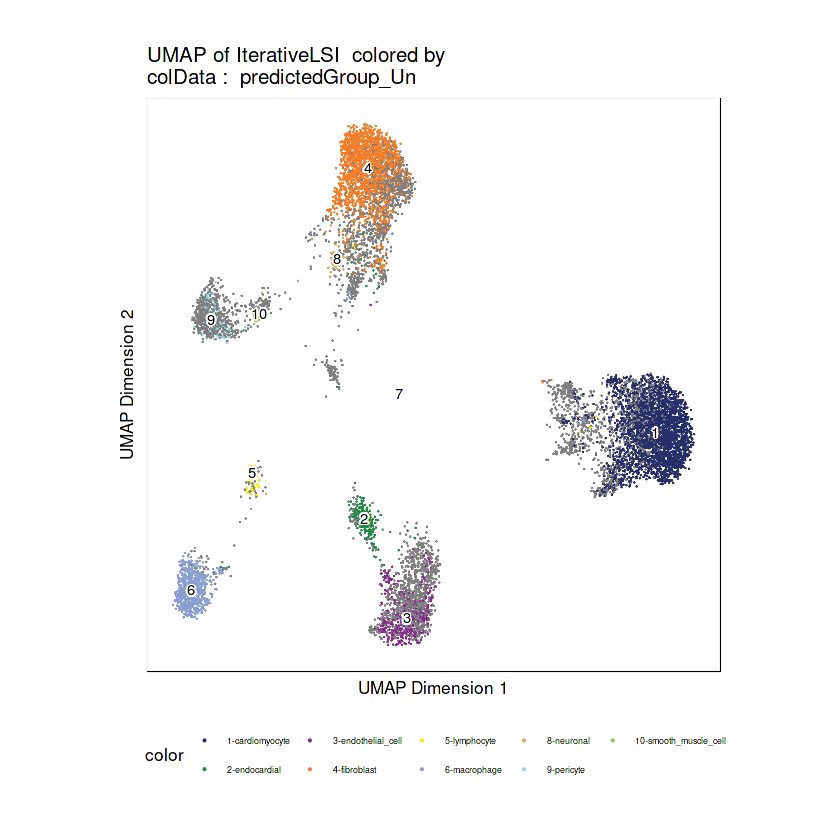

In [28]:
# Visualize results of unconstrained integration (i.e., overlay scRNA labels on scATAC cells)
p1 <- plotEmbedding(
    proj3, 
    colorBy = "cellColData", 
    name = "predictedGroup_Un", 
    pal = pal
)
p1

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3051766cc0cad4-Date-2024-07-22_Time-15-15-30.762167.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3051766cc0cad4-Date-2024-07-22_Time-15-15-30.762167.log



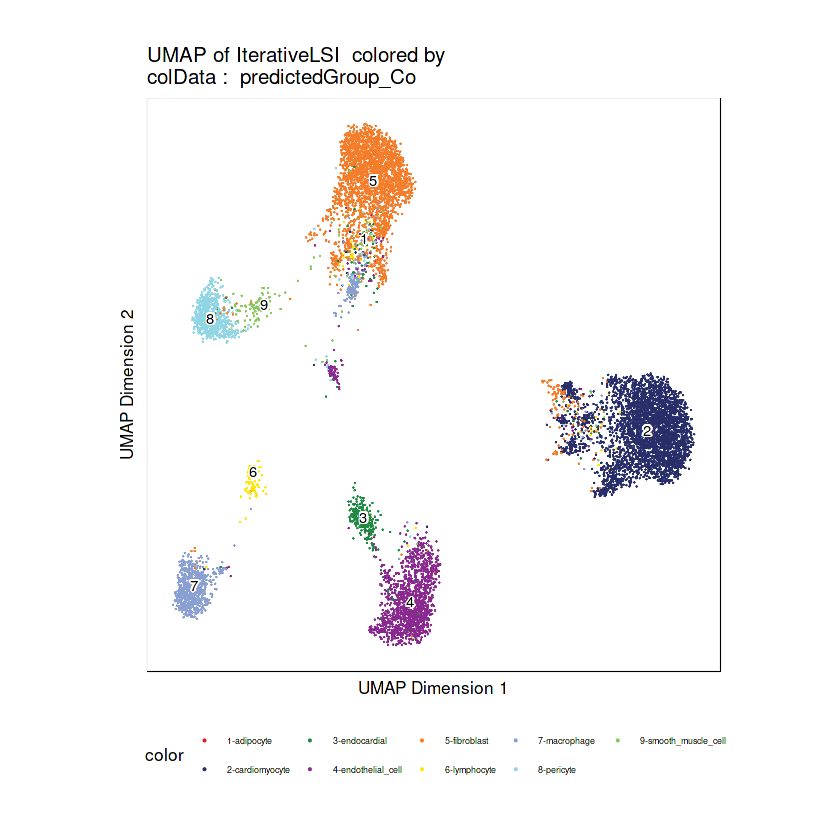

In [29]:
# Visualize results of constrained integration (i.e., overlay scRNA labels on scATAC cells)
p2 <- plotEmbedding(
    proj3, 
    colorBy = "cellColData", 
    name = "predictedGroup_Co", 
    pal = pal
)
p2

In [30]:
plotPDF(p1,p2, name = "Plot-UMAP-RNA-Integration.pdf", ArchRProj = proj3, addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!

Plotting Ggplot!



In [31]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj3, outputDirectory = paste0(OUT_DIR, "/ArchROut_Integration_ENCSR681OLJ"), load = FALSE)

Copying ArchRProject to new outputDirectory : /zata/zippy/phanh/encode/snMultiome/adult_heart/anchored_on_cCREs_w_integration/ArchROut_Integration_ENCSR681OLJ

Copying Arrow Files...

Copying Arrow Files (1 of 1)

Getting ImputeWeights

Dropping ImputeWeights...

Copying Other Files...

Copying Other Files (1 of 5): Embeddings

Copying Other Files (2 of 5): ENCSR681OLJ

Copying Other Files (3 of 5): IterativeLSI

Copying Other Files (4 of 5): Plots

Copying Other Files (5 of 5): RNAIntegration

Saving ArchRProject...



In [32]:
# Repeat, but this time add info to Arrow files
proj3 <- addGeneIntegrationMatrix(
    ArchRProj = proj3, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = seRNA,
    addToArrow = TRUE,
    force= TRUE,
    groupList = groupList,
    groupRNA = "cluster",
    nameCell = "predictedCell",
    nameGroup = "predictedGroup",
    nameScore = "predictedScore"
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-305176ca048ac-Date-2024-07-22_Time-15-16-03.545182.log
If there is an issue, please report to github with logFile!

2024-07-22 15:16:03.604654 : Running Seurat's Integration Stuart* et al 2019, 0.001 mins elapsed.

2024-07-22 15:16:04.507742 : Checking ATAC Input, 0.016 mins elapsed.

2024-07-22 15:16:04.672982 : Checking RNA Input, 0.019 mins elapsed.

2024-07-22 15:16:11.374021 : Found 14301 overlapping gene names from gene scores and rna matrix!, 0.13 mins elapsed.

2024-07-22 15:16:11.376917 : Creating Integration Blocks, 0.131 mins elapsed.

2024-07-22 15:16:11.389408 : Prepping Interation Data, 0.131 mins elapsed.

2024-07-22 15:16:12.005635 : Computing Integration in 2 Integration Blocks!, 0 mins elapsed.

2024-07-22 15:18:26.524138 : Block (1 of 2) : Plotting Joint UMAP, 2.242 mins elapsed.

2024-07-22 15:18:55.073375 : Block (2 of 2) : Plotting Joint UMAP, 2.718 mins elapsed.

2024-07-22 15:19:13.68695 : Transferring 

In [33]:
# Check that the GeneIntegrationMatrix has been added
getAvailableMatrices(proj3)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "PeakMatrix"           
[4] "TileMatrix"

In [34]:
# Add impute weights
proj3 <- addImputeWeights(proj3)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-305176282834ea-Date-2024-07-22_Time-15-21-00.034658.log
If there is an issue, please report to github with logFile!

2024-07-22 15:21:00.091486 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



In [35]:
# Set known marker genes
markerGenes  <- c(
    # Fibroblast
    "DCN", "LUM", "PODN",
    # Macrophages
    "C1QB", "CD163", "MS4A7",
    # Endothelial
    "EGFL7", "CLDN5", "VWF",
    # Smooth muscle cells
    "GJA4", "FOXL1", "CARMN",
    # Vascular smooth muscle cells
    "FOXC2", "MYLK",
    # T lymphocytes
    "IFNG", "CD3D", "GZMA",
    # Schwann cells
    "S100B", "SOX10", "PLP1",
    # B lymphocytes
    "IGHJ6", "IGHA1", "IGHA2",
    # Mast cells
    "GATA1", "MRGPRX2", "HDC",
    # Mesothelial cells
    "HAS1", "WT1",
    # Adipocytes
    "ADIPOQ", "CIDEC", "LEP", "SLC36A2", "P2RX5", "UCP1", "CIDEA", "PRDM16", "LHX8", "EPSTI1", "MC2R", "FFAR2", "PIKFYVE", "CYP11B2",
    "TLR2", "TLR4", "ADRB1", "ADRB2", "ADRB3", "FABP4", "TNFRSF9", "TBX1", "TMEM26", "TCF21", "ADIPOQ", "CFD", "ACVR1C", "SLC2A4",
    "LPIN1", "PLIN1", "PCK1", "PPARG", "RETN", "MEST", "ADM2", "STAT6", "TFE3", "CPPED1", "SLC1A5", "ACSL1", "CAR3", "CAVIN1", "AGT",
    "BCAT2", "PNPLA2", "CIDEC", "CDO1", "APOC1", "MMP2", "POSTN", "LOX", "COL6A2", "ZBTB16", "GULP1", "FZD4", "TRIP10", "FGF7", "MAOB",
    "SOCS1", "NNMT", "AOC3", "H6PD", "CYP27A1", "EBF2", "MNDA", "HSD11B1", "AR", "GDF10", "CYP1B1", "STEAP4", "CCL11", "DEPTOR", "TUSC5",
    "FMO1", "ACADSB", "XDH", "PTGES", "CREB3L1", "ANGPTL2", "ADH1", "LBP", "NMB", "RARRES2", "EGFR", "CPXM1", "C3", "ADAMTS5", "MT2A",
    "METRN", "METRNL", "MYO1C", "NQO1", "AQP5", "TSPO", "AZGP1", "LRP1", "PDE3B", "LGALS12", "SERPINF1", "CPT1B", "ELOVL3", "PPARGC1A", 
    "MPZL1", "CITED1", "DPT", "HOXC9", "ZNF423", "ESM1",
    # Cardiomyocytes
    "TNNT2", "NKX2-5", "NPPA", "TNNC1", "ADM2", "ALCAM", "NPPA", "FGF2", "NPPB", "TNNI3", "TNNT2", "ANKRD1", "NPPC", "DES", "HAND2", "HAND1",
    "GATA4", "GATA6", "MYL2", "PNMT", "ACTA1", "CD36", "VLDLR", "ALPK3", "RBM24", "FABP4", "CKMT2", "MYH7B", "MYOM2", "PDLIM5", "MYH7", "PLN",
    "TCAP", "SORBS2", "RYR2", "ACTC1", "MYL3", "PDE3D", "NEXN", "FHL2", "MYBPC3", "MYH6", "TTN", "GPIHBP1", "AQP1", "DMD", "MFN2", "ASB2", "ART3",
    "RRAD", "JPH2", "HSPB7", "MYOZ2", "ENO3", "TRDN", "ACTN2", "TNNI1", "SMPX", "MYL7", "TBX20", "TRIM63", "MB", "CTGF", "MYL4", "LOX", "CTNNB1",
    "CPT1A", "SOX18", "NOTCH1", "SLN", "CSRP3", "TXLNB", "ATP2A2", "CKMT2", "CKB", "CXCR4", "IL11RA", "MITF", "ZFPM2", "BDNF", "GJA5", "FMOD",
    "MTTP", "SLC5A1", "ADIPOQ", "TRPV1", "HAMP", "SGPL1", "HMGB2", "STC1", "FGF23", "STRN", "HEY2", "ADIPOR1", "ADIPOR2", "PDE1A", "BMP4", "CASQ2", "TMP1",
    # Adipocytes progenitor cells
    "FGF10", "WT1", "SCARA5", "HOXC8", "TCF7L1", "HOXC9", "EBF2", "NRG4",
    # Cardiac stem and precursor cells
    "NKX2-5", "ISL1", "MESP1", "ADGRL2", "TBX3", "TBX4", "WNT5A", "ANKRD1"
    
    
    
  )
markerGenes = unique(markerGenes)
markerGenes_geneIDs = genes_df[genes_df$gene_name %in% markerGenes,]$symbol
markerGenes_geneIDs = markerGenes_geneIDs[!grepl("PAR_Y", markerGenes_geneIDs)]
head(markerGenes_geneIDs)
markerGenes_geneIDs_integration = markerGenes_geneIDs[markerGenes_geneIDs %in% getFeatures(ArchRProj = proj3, useMatrix = "GeneIntegrationMatrix", select = NULL, ignoreCase = TRUE)]
length(markerGenes_geneIDs)
length(getFeatures(ArchRProj = proj3, useMatrix = "GeneIntegrationMatrix", select = NULL, ignoreCase = TRUE))
length(markerGenes_geneIDs_integration)

[1] "ENSG00000142611.17" "ENSG00000049249.9"  "ENSG00000049239.13"
[4] "ENSG00000175206.11" "ENSG00000120937.9"  "ENSG00000116688.18"

[1] 231

[1] 14301

[1] 5

In [36]:
# Replot marker gene UMAP using Gene Expression from RNA
p1 <- plotEmbedding(
    ArchRProj = proj3, 
    colorBy = "GeneIntegrationMatrix", 
    name = markerGenes_geneIDs_integration, 
    continuousSet = "horizonExtra",
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj3)
)
# Replot marker gene UMAP using Gene Scores Matrix from ATAC
p2 <- plotEmbedding(
    ArchRProj = proj3, 
    colorBy = "GeneScoreMatrix", 
    continuousSet = "horizonExtra",
    name = markerGenes_geneIDs, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj3)
)

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3051763d422c11-Date-2024-07-22_Time-15-21-13.406065.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneIntegrationMatrix

Getting Matrix Values...

2024-07-22 15:21:13.578221 : 

1 


Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3051763d422c11-Date-2024-07-22_Time-15-21-13.406065.log

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-3051767d8df002-Date-2024-07-22_Time-15-21-21.897286.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2024-07-22 15:21:22.077696 : 

1 


Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.”


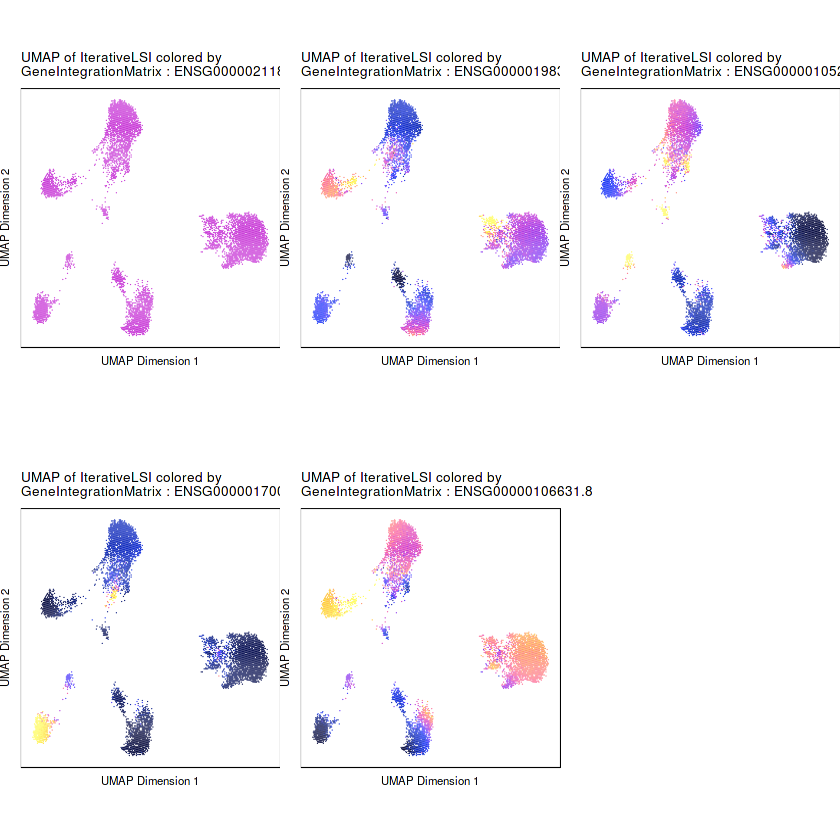

In [37]:
p1c <- lapply(p1, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

p2c <- lapply(p2, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})

do.call(cowplot::plot_grid, c(list(ncol = 3), p1c))

In [38]:
plotPDF(plotList = p1, 
    name = "Plot-UMAP-Marker-Genes-RNA-W-Imputation.pdf", 
    ArchRProj = proj3, 
    addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!



In [39]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj3, outputDirectory = paste0(OUT_DIR, "/ArchROut_Integration_ENCSR681OLJ"), load = FALSE)

Copying ArchRProject to new outputDirectory : /zata/zippy/phanh/encode/snMultiome/adult_heart/anchored_on_cCREs_w_integration/ArchROut_Integration_ENCSR681OLJ

Copying Arrow Files...

Copying Arrow Files (1 of 1)

Getting ImputeWeights

Dropping ImputeWeights...

Copying Other Files...

Copying Other Files (1 of 5): Embeddings

Copying Other Files (2 of 5): ENCSR681OLJ

Copying Other Files (3 of 5): IterativeLSI

Copying Other Files (4 of 5): Plots

Copying Other Files (5 of 5): RNAIntegration

Saving ArchRProject...



In [42]:
proj3$predictedGroup_Un

[1] "NA"                 "cardiomyocyte"      "NA"                
    [4] "NA"                 "cardiomyocyte"      "NA"                
    [7] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
   [10] "NA"                 "fibroblast"         "NA"                
   [13] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
   [16] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
   [19] "NA"                 "NA"                 "cardiomyocyte"     
   [22] "cardiomyocyte"      "NA"                 "cardiomyocyte"     
   [25] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
   [28] "cardiomyocyte"      "NA"                 "macrophage"        
   [31] "NA"                 "cardiomyocyte"      "fibroblast"        
   [34] "cardiomyocyte"      "cardiomyocyte"      "NA"                
   [37] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
   [40] "cardiomyocyte"      "cardiomyocyte"      "NA"                
   [43] "fibroblast"         "cardiomyocyte"      "fibroblast"        
   [46] "NA"                 "cardiomyocyte"      "NA"                
   [49] "cardiomyocyte"      "NA"                 "cardiomyocyte"     
   [52] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [55] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
   [58] "NA"                 "cardiomyocyte"      "NA"                
   [61] "cardiomyocyte"      "macrophage"         "cardiomyocyte"     
   [64] "fibroblast"         "cardiomyocyte"      "NA"                
   [67] "cardiomyocyte"      "NA"                 "cardiomyocyte"     
   [70] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [73] "fibroblast"         "cardiomyocyte"      "NA"                
   [76] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
   [79] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [82] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [85] "cardiomyocyte"      "endocardial"        "cardiomyocyte"     
   [88] "cardiomyocyte"      "NA"                 "macrophage"        
   [91] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
   [94] "NA"                 "fibroblast"         "NA"                
   [97] "NA"                 "NA"                 "cardiomyocyte"     
  [100] "fibroblast"         "NA"                 "cardiomyocyte"     
  [103] "cardiomyocyte"      "NA"                 "cardiomyocyte"     
  [106] "NA"                 "cardiomyocyte"      "fibroblast"        
  [109] "NA"                 "NA"                 "cardiomyocyte"     
  [112] "cardiomyocyte"      "NA"                 "NA"                
  [115] "NA"                 "NA"                 "NA"                
  [118] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
  [121] "cardiomyocyte"      "NA"                 "NA"                
  [124] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
  [127] "fibroblast"         "NA"                 "NA"                
  [130] "cardiomyocyte"      "cardiomyocyte"      "fibroblast"        
  [133] "cardiomyocyte"      "NA"                 "NA"                
  [136] "cardiomyocyte"      "cardiomyocyte"      "NA"                
  [139] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [142] "NA"                 "NA"                 "NA"                
  [145] "cardiomyocyte"      "cardiomyocyte"      "NA"                
  [148] "NA"                 "cardiomyocyte"      "cardiomyocyte"     
  [151] "cardiomyocyte"      "cardiomyocyte"      "NA"                
  [154] "NA"                 "NA"                 "cardiomyocyte"     
  [157] "cardiomyocyte"      "NA"                 "cardiomyocyte"     
  [160] "cardiomyocyte"      "NA"                 "NA"                
  [163] "cardiomyocyte"      "NA"                 "NA"                
  [166] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [169] "NA"                

In [43]:
proj3$predictedGroup_Co

[1] "macrophage"         "cardiomyocyte"      "cardiomyocyte"     
    [4] "fibroblast"         "cardiomyocyte"      "cardiomyocyte"     
    [7] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [10] "cardiomyocyte"      "fibroblast"         "fibroblast"        
   [13] "endothelial_cell"   "cardiomyocyte"      "cardiomyocyte"     
   [16] "endothelial_cell"   "cardiomyocyte"      "cardiomyocyte"     
   [19] "cardiomyocyte"      "smooth_muscle_cell" "cardiomyocyte"     
   [22] "cardiomyocyte"      "endothelial_cell"   "cardiomyocyte"     
   [25] "fibroblast"         "cardiomyocyte"      "cardiomyocyte"     
   [28] "cardiomyocyte"      "cardiomyocyte"      "macrophage"        
   [31] "cardiomyocyte"      "cardiomyocyte"      "fibroblast"        
   [34] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [37] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [40] "cardiomyocyte"      "cardiomyocyte"      "macrophage"        
   [43] "fibroblast"         "cardiomyocyte"      "fibroblast"        
   [46] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [49] "cardiomyocyte"      "endothelial_cell"   "cardiomyocyte"     
   [52] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [55] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [58] "cardiomyocyte"      "cardiomyocyte"      "fibroblast"        
   [61] "cardiomyocyte"      "macrophage"         "cardiomyocyte"     
   [64] "fibroblast"         "cardiomyocyte"      "cardiomyocyte"     
   [67] "cardiomyocyte"      "endothelial_cell"   "cardiomyocyte"     
   [70] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [73] "fibroblast"         "cardiomyocyte"      "cardiomyocyte"     
   [76] "macrophage"         "cardiomyocyte"      "cardiomyocyte"     
   [79] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [82] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [85] "cardiomyocyte"      "endocardial"        "cardiomyocyte"     
   [88] "cardiomyocyte"      "cardiomyocyte"      "macrophage"        
   [91] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
   [94] "cardiomyocyte"      "fibroblast"         "endocardial"       
   [97] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [100] "fibroblast"         "cardiomyocyte"      "cardiomyocyte"     
  [103] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [106] "cardiomyocyte"      "cardiomyocyte"      "fibroblast"        
  [109] "macrophage"         "endothelial_cell"   "cardiomyocyte"     
  [112] "cardiomyocyte"      "fibroblast"         "cardiomyocyte"     
  [115] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [118] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [121] "cardiomyocyte"      "fibroblast"         "cardiomyocyte"     
  [124] "fibroblast"         "cardiomyocyte"      "cardiomyocyte"     
  [127] "fibroblast"         "cardiomyocyte"      "fibroblast"        
  [130] "cardiomyocyte"      "cardiomyocyte"      "fibroblast"        
  [133] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [136] "cardiomyocyte"      "cardiomyocyte"      "fibroblast"        
  [139] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [142] "endothelial_cell"   "fibroblast"         "endothelial_cell"  
  [145] "cardiomyocyte"      "cardiomyocyte"      "fibroblast"        
  [148] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [151] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [154] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [157] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [160] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [163] "cardiomyocyte"      "endothelial_cell"   "macrophage"        
  [166] "cardiomyocyte"      "cardiomyocyte"      "cardiomyocyte"     
  [169] "cardiomyocyte"     